In [ ]:
# This file is a implementation of the Recurrent Neural Network model 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
model = Sequential()
eurusd_train = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_train_normed.csv")
eurusd_test = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\eurusd_test_normed.csv")
eurusd_train = eurusd_train.replace(np.nan, 0)
eurusd_test = eurusd_test.replace(np.nan, 0)


Using TensorFlow backend.


In [3]:
# This take original data with trading features and then transforms the data in to a format which is
# able to be passed to the RNN model
# Chose the training size of the data
DATA_SIZE = 5000
train_original = eurusd_train.iloc[:DATA_SIZE,:].reset_index(drop=False) # eurusd_train.iloc[-DATA_SIZE:,:]
#test_original = eurusd_test.iloc[:DATA_SIZE,:]
TEST_SIZE = DATA_SIZE*2 + 30 
# using the next batch of the training data for validation
test_original = eurusd_train.iloc[DATA_SIZE + 30: TEST_SIZE,:].reset_index(drop=False)
features_to_use = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff", 
                   "MF_ema_diff","LF_ema_diff", "LDN", "NY", "Asia", "target"]

#### Create Tensor Data Shape ######################################
# Data needs to be reshaped into 3D tensor
train_sample = train_original[features_to_use].values
test_sample = test_original[features_to_use].values

# this creates your dataset with the lookback periods it needs to use.

import numpy as np
# this lookback over a set period as the memory for the LSTM
look_back = 60
def create_dataset(dataset, populate_target ,look_back=look_back):
  dataX, dataY, target_dates = [], [], []
  for i in range(len(dataset)-look_back+1):
      # this takes the very last col as the target
    a = dataset[i:(i+look_back), :-1]
    dataX.append(a)
    # this code assumes that the target vector is the very last col.
    dataY.append(dataset[i + look_back - 1, -1])
    if populate_target:
        target_dates.append(test_original['Date'].loc[i + look_back - 1])
  return np.array(dataX), np.array(dataY), target_dates

# Implement the data transform on the training and train target data 
train_sample_transformed = create_dataset(train_sample,False, look_back)
train_data = train_sample_transformed[0]
train_target = train_sample_transformed[1]
# Implement the data transform on the training and train target data
test_sample_transformed = create_dataset(test_sample, True, look_back)
test_data = test_sample_transformed[0]
test_target = test_sample_transformed[1]
target_dates = test_sample_transformed[2]

# reshape the data which adds another list around every observation
train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], 1)

test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
test_target = test_target.reshape(test_target.shape[0], 1)

#print(test_results['logret'])

In [10]:
'''
This code will create the LSTM model using the Keras package
The layers and model architecture are created such that we have 4 hidden LSTM nodes which feed a one neuron node for output 
using SOFTMAX activation
'''
# TODO: Functionise the belwo code such that we can iterate over various different model architectures.
# need to try understand the input shapes and what is required of it.
# look at tutorials where they use this data
# Friday: GOAL have the LSTM working with your input (and variable data set)
# BONUS GOAL: simulate trendy and mean reverty data.
# batch_input_shape (no_obversations,timelookback, features)
# set batch size (this is how often the weights will update
# from keras moodule
# keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', 
# recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
# recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
# recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
# recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)
BATCH_SIZE = 300
no_features = train_data.shape[2]
model = Sequential()
model.add(LSTM(4,batch_input_shape = (None,look_back,no_features), return_sequences = True, dropout= 0.2))
model.add(LSTM(1, return_sequences = False, activation="softmax"))

#model.add(Dense(2, activation= "softmax"))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 60, 4)             224       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1)                 24        
Total params: 248
Trainable params: 248
Non-trainable params: 0
_________________________________________________________________


In [33]:
# model training
'''
history = model.fit(x_train,y_train, epochs=100,validation_data=(x_test,y_test))
results = model.predict(x_test)
'''
 # train the lSTM model
history = model.fit(train_data,train_target,epochs = 300,validation_data=(test_data,test_target), verbose=0)

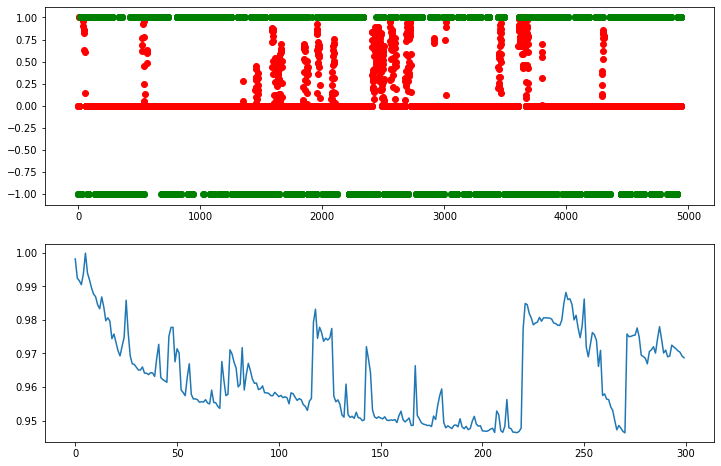

In [35]:
# plot the predicted result (red ) vs the actual output.
# Here the red at 0 implies 0% probability of being a buy.
import matplotlib.pyplot as plt
results = model.predict(test_data)
fig , ax = plt.subplots(2,1,figsize=(12,8))
ax[0].scatter(range(len(results)), results, c = "r")
ax[0].scatter(range(len(test_target)), test_target, c = "g")
# lets see the history of the error update.
# want a smooth learning line
ax[1].plot(history.history['loss'])
plt.show()


array([[-3.77077251, -3.62112174, -2.03388392, -4.85746873, -2.01641818,
         0.33070086],
       [-4.09020146, -3.69558669, -2.07626712, -4.83655507, -2.02458851,
         0.32852463],
       [-4.60197656, -3.81557922, -2.1431084 , -4.86914407, -2.03328911,
         0.32627671],
       ...,
       [-0.80929306,  0.09202221, -0.31229262, -0.47708991, -0.71461784,
        -1.06383853],
       [-0.75726148,  0.09778996, -0.30904073, -0.46443473, -0.71445716,
        -1.06284846],
       [-0.68397369,  0.10862184, -0.30307008, -0.4479426 , -0.71424005,
        -1.06185307]])

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
def signal(x, thold):
    '''
    :param x: 
    :return: signal to trade 
    '''
    if x >= thold:
        return 1
    elif x <= (1-thold):
        return -1
    else:
        return 0
predicted = [signal(i, 0.55) for i in results]

true_class = [np.sign(i[0]) for i in test_target]
print(accuracy_score(true_class, predicted))

print(pd.DataFrame(
    confusion_matrix(true_class, predicted),
    columns=['Predicted Buy',"shithouse",'Predicted Sell'],
    index=['True Buy',"shithouse",'True Sell']
))
# To do --> Create a relatively realistic backtester (probably needs to be a .py file engine)
# Run the model on the real data (explore running on a server. tie a small subset of data to see how long it might actually take?
# test model on test data and see if returns work.
# create a timeseries that generates a trendy or non trendy price series on same frequency as the hourly eurusd data.
# test the model to see if it can pick this up. 
# potential GM questions, LSTM architecture? Best practises around standardisation? Are you implementing the notes and points reaised by the
# examiners?
# Ultimate GOAL: create a trend baseded model which can actually pick up price action and place bet sizes which are relatively intelligent.
# is there a way of testign some neuro fuzzy logic perhaps?
# Probabitily distribution of outcomes for each trade based on the trend and external factors

0.5347095729609391
           Predicted Buy  shithouse  Predicted Sell
True Buy            2432          8             108
shithouse              0          0               0
True Sell           2146         37             210


In [1]:
from keras.layers import Dense
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from trading_eng.ml_trading_module import *
from trading_eng.model_functions import *
import datetime
import sys

file_location = r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyData.csv"
performance_store = {"data_size" : [], "Accuracy_Score" : [], "ntree": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
params_dict = set_params_random_forests()
lstm_dict = set_params_LSTM()
use_random_train_data = params_dict['use_random_train_data']
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
EPOCH = lstm_dict['EPOCH']
first_layer = lstm_dict['first_layer']
second_layer = lstm_dict['second_layer']
look_back = lstm_dict['look_back'] 

# [i for i in range(25,301,25)] # [21, 66]
# if running pca, max features can only be same or less than the full total of features
test_buffer = params_dict['test_buffer']
data_size = params_dict['data_size'] #  initially using 1500 training points
# I.e. append the data into one df over each training window, but also use all available up until that point
concat_results = params_dict['concat_results']
# if the number is > 1, then the code takes that as the number of test points you want to use
test_split = params_dict['test_split'] # roughly one month test ahead, which is a one month retrain period
# signal threshold, when using classifier
thold = params_dict['thold']
total_data_needed = get_total_data_needed(test_split,data_size,test_buffer)
# standardisation window
window = params_dict['window']
###### Set Targets ##############
trade_horizon = params_dict['trade_horizon'] # in hours
use_risk_adjusted = params_dict['use_risk_adjusted'] # if True: training on the sharpe return else raw
use_binary = params_dict['use_binary'] # set to true if you are using the risk adjusted and want it binary for classification score
use_classifier = params_dict['use_classifier']
use_pca = params_dict['use_pca'] # if = 0 then implies do not use pca in the model
use_separated_chunk = params_dict['use_separated_chunk']
################### Standardise Entire Dataset using rolling lookback windows ###############
data_normed, model_features, features_to_standardise = initialise_process(file_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca,use_random_train_data)
#data_normed = data_normed.replace(np.nan, 0)
start_row = data_size
 # Use a rolling window to train and test
################ Loop through the full dataset in terms of the training and testing.
if use_random_train_data:
    random_data_location = r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyRandomTrendLSTM.csv"
    train, model_features, features_to_standardise = initialise_process(random_data_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca, use_random_train_data)
    test, model_features, features_to_standardise  = initialise_process(file_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca, 
                                                use_random_train_data= False)
    if test.shape[0] <= (look_back+test_buffer+trade_horizon):
        sys.exit()
    if use_pca > 0:
        train, test, var_explained = get_pca_features(train,test, features_to_standardise, use_pca)
    train_sample = train[model_features].values
    test_sample = test[model_features].values
print(use_risk_adjusted)

Using TensorFlow backend.


C:\Users\edgil\Documents\Masters\dissertation\code64\venv\trading_eng\ml_trading_module.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).sum().values[::-1]/data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).std().values[::-1]


True


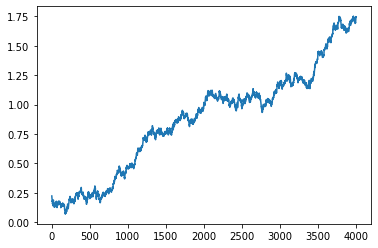

NameError: name 'train_data' is not defined

In [6]:
import matplotlib.pyplot as plt
#plt.plot(train_target)
train['CCY'].plot()
plt.show()
train_sample = train[model_features].iloc[:500].values
test_sample = test[model_features].values
print(train_data.shape)

In [14]:
import numpy as np
train_sample = train[model_features].iloc[:500].values
test_sample = train[model_features].iloc[:500].values # test[model_features].values
train_data , train_target, null_dates = create_dataset(train_sample, False, look_back, test)
test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)

# reshape seems to add another list around every observation
train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], 1)
test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
test_target = test_target.reshape(test_target.shape[0], 1)
#### Set up model parameters
# Build up the model
BATCH_SIZE = 19# train_data.shape[0]
no_features = train_data.shape[2]
model = Sequential()
model.add(LSTM(first_layer, batch_input_shape = (BATCH_SIZE,look_back,no_features), return_sequences = True))
model.add(LSTM(second_layer, return_sequences = False, activation="softmax"))
model.add(Dense(8, activation = "tanh"))
model.add(Dense(1, activation = "linear"))
model.compile(loss = "mse", optimizer="adam", metrics = ['accuracy'])
model.summary()
lstm_engine = model.fit(train_data,train_target,epochs = 500, verbose = 0, batch_size=BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (19, 64, 32)              4992      
_________________________________________________________________
lstm_6 (LSTM)                (19, 16)                  3136      
_________________________________________________________________
dense_5 (Dense)              (19, 8)                   136       
_________________________________________________________________
dense_6 (Dense)              (19, 1)                   9         
Total params: 8,273
Trainable params: 8,273
Non-trainable params: 0
_________________________________________________________________


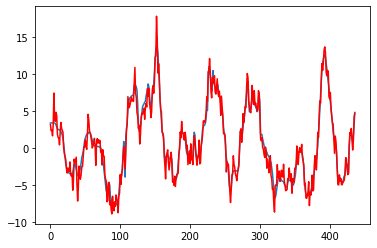

In [15]:
len(train_data[0])

plt.plot(model.predict(test_data, batch_size = BATCH_SIZE) )
plt.plot(test_target, c = 'r')

In [16]:
test_data.shape

(437, 64, 6)

In [5]:
#print(test[model_features].tail(50))
import matplotlib.pyplot as plt
xy = train_data # or test_data
yy = train_target
results = model.predict(xy, batch_size=BATCH_SIZE) # test_data
fig , ax = plt.subplots(2,1,figsize=(12,8))
ax[0].scatter(range(len(results)), results, c = "r")
ax[0].scatter(range(len(yy)), yy, c = "g")
# lets see the history of the error update.
# want a smooth learning line
ax[1].plot(lstm_engine.history['loss'])
plt.show()
predicted = [signal(i, thold) for i in results]
predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
# calculate the returns of the signal
test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
# no shift needed as we have already done that in previous step
test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
strat_return = test_results['strat_returns'].sum()
information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))

NameError: name 'train_data' is not defined

NameError: name 'test_results' is not defined

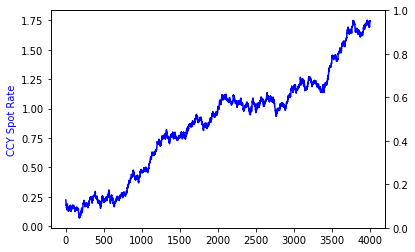

In [122]:
# plotting the buy (green) and sell (red) signals across the testing period alongside the currency move as well. 
ax1 = plt.plot()
s1 = train['CCY']
plt.plot(s1,'b')
plt.ylabel('CCY Spot Rate',color='b')

ax2 = plt.gca().twinx()
s2 = test_results['strat_returns_sum'].loc[test_results['scaled_signal'] <0 ]
ax2.plot(s2, 'r*')
plt.ylabel('Cumulative Returns', color='r')
s3 = test_results['strat_returns_sum'].loc[test_results['scaled_signal'] >0 ]

ax2.plot(s3, 'g*')
plt.show()

In [18]:
results = model.predict(test_data, batch_size= BATCH_SIZE)
predicted = [np.sign(i) for i in results] #[signal(i,thold ) for i in results]
true_class = [np.sign(i) for i in train_target]
print(accuracy_score(true_class, predicted))
#print(len(predicted))
#print(len(true_class))
from sklearn import metrics
metrics.mean_squared_error(true_class,predicted)

0.9519450800915332


0.19221967963386727

In [4]:
def create_dataset(dataset, populate_target, look_back, test):
    '''
    This creates the data for  passing to the LSTM module
    :param dataset:
    :param populate_target:
    :param look_back:
    :return:
    '''
    dataX, dataY, target_dates = [], [], []
    for i in range(len(dataset) - look_back + 1):
        # this takes the very last col as the target
        a = dataset[i:(i + look_back), :-1]
        dataX.append(a)
        # this code assumes that the target vector is the very last col.
        dataY.append(dataset[i + look_back - 1, -1])
        if populate_target:
            target_dates.append(test['Date'].loc[i + look_back - 1])
    return np.array(dataX), np.array(dataY), target_dates

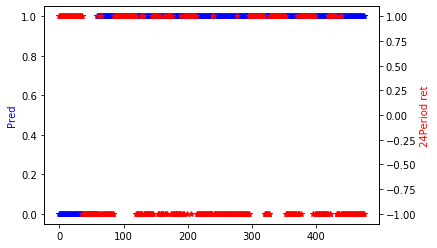

In [27]:
#print(test_original[['Date',"CCY","Predictions", "logret", "strat_returns"]].head(50)) # "strat_returns_sum", "logret"
# plotting the results of the output vs predicted
ax1 = plt.plot()
s1 = test_original['Predictions']
plt.plot(s1,'b*')
plt.ylabel('Pred',color='b')
ax2 = plt.gca().twinx()
s2 = test_original['target']
ax2.plot(s2, 'r*')
plt.ylabel('24Period ret', color='r')
plt.show()

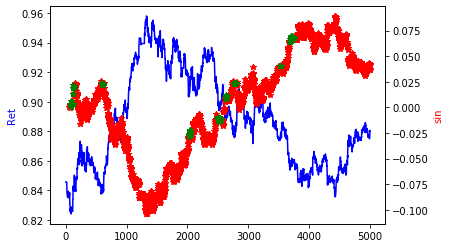

In [40]:
# plotting the buy (green) and sell (red) signals across the testing period alongside the currency move as well. 
ax1 = plt.plot()
s1 = test_original['CCY']
plt.plot(s1,'b')
plt.ylabel('CCY Spot Rate',color='b')

ax2 = plt.gca().twinx()
s2 = test_original['strat_returns_sum'].loc[test_original['scaled_signal'] <0 ]
ax2.plot(s2, 'r*')
plt.ylabel('Cumulative Returns', color='r')
s3 = test_original['strat_returns_sum'].loc[test_original['scaled_signal'] >0 ]
ax2.plot(s3, 'g*')
plt.show()

In [ ]:
test_original.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\signal_prediction_60_lookback_300pok_traindata.csv"
                     ,index = False)

In [ ]:
'''
#########################################################################################
                   Rough work on Dense NN model and other code variations
#########################################################################################
'''
from keras.models import Model # Dense
model.add(Dense(units=2, activation='relu', input_dim=2))
model.add(Dense(units=1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
x_train = np.array([[1,1],[1,0],[0,1],[0,0]])
y_train = np.array([0,1,0,0])
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(x_train, y_train, epochs=5, batch_size=32)

# set up the training data for the model
# we must normalise the inputs so they can pick up the correct values
data = [[[(i+j)/100]for i in range(0,5)] for j in range(0,200)]
target = [[(i+5)/100] for i in range(0,100)]
npData = np.array(data, dtype = float)
npTarget = np.array(target, dtype = float)
npData.shape
x_train, x_test, y_train, y_test = train_test_split(npData,npTarget,test_size = 0.2, random_state = 4)
# data stored as data[row_obversation][first_col_data][value_of_col]


# this code sets up the LSTM model.
'''
Original
model = Sequential()
model.add(LSTM((1),batch_input_shape = (None,5,1), return_sequences = True))
model.add(LSTM((1), return_sequences = False))
model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
model.summary()
'''
features_to_use = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",	"MF_ema_diff","LF_ema_diff"]
train_sample = eurusd_train[features_to_use].iloc[-DATA_SIZE:,:].values
#test_sample = eurusd_test.iloc[:200,features_to_use].values

In [ ]:
'''
This code acts as a test center for the code which will run on the cloud server.
All details on the server and CPU spce is available at the following
https://www.paperspace.com/
'''
# Test code for the cloud server.
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from trading_eng.ml_trading_module import create_train_test_file, create_dataset, get_accuracy, signal
import datetime
model = Sequential()
data_file = pd.read_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyData.csv") # pd.read_csv(r"/storage/eurusd_train_normed.csv")
data_file = data_file.replace(np.nan, 0)
#eurusd_test = eurusd_test.replace(np.nan, 0)
performance_store = {"data_size" : [], "Accuracy_Score" : [], "epochs": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
look_back = 66 # [21, 66]
trade_horizon = 24
model_features = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",
                   "MF_ema_diff","LF_ema_diff", "LDN", "NY", "Asia", "target"]
test_buffer = 5
data_size = 25
test_split = 0.75
total_data_needed = int(data_size*(1 + test_split)) + test_buffer
###### Set Targets ##############
trade_horizon = 24 # in hours
use_risk_adjusted = False # if True: training on the sharpe return else raw
data_file["target"] = calculate_target(data_file,trade_horizon,use_risk_adjusted)
################### Standardise Entire Dataset using rolling lookback windows ###############
featrues_to_standardise = ["spot_v_HF", "spot_v_MF", "spot_v_LF", "HF_ema_diff",
                                "MF_ema_diff","LF_ema_diff"]
# roughly 3 yrs of data slightly less actually
window = 15000
data_normed = standardise_data(data_file,model_features ,featrues_to_standardise, window)
# add extra features non standardised
data_normed['Date'] = data_file.loc[window:,:]
data_normed['CCY'] = data_file.loc[window:,:]
data_normed = data_normed.replace(np.nan, 0)
start_row = 0
################ Loop through the full dataset in terms of the training and testing #############################
while start_row < data_file.shape[0]:
    # first check if there is enough data left
    if (start_row + total_data_needed) > data_file.shape[0]:
        # if we are about to go over the limit, then just return the last data_size + test size proportion of data
        trunc_data = data_file.iloc[-total_data_needed:,:]
    # we need to increment over the data size
    if use_separated_chunk:
        # this means we jump across the full previous train and test data
        trunc_data = data_file.loc[start_row:,:]
        start_row += total_data_needed
    if use_rolling_chunk:
        # this rools the data so that the new training will overlap on the old test set and create a new separated test set
        trunc_data = data_file.loc[start_row:,:]
        start_row += data_size
    # standardise the data
    #################### Set up training and testing ########################
    
    # create data_set
    train , test = create_train_test_file(trunc_data, data_size, test_split)
    train_sample = train[model_features].values
    test_sample = test[model_features].values
     # Parse the values into the LSTM format
    train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
    test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)
    
    # reshape seems to add another list around every observation
    train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
    train_target = train_target.reshape(train_target.shape[0], 1)
    test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
    test_target = test_target.reshape(test_target.shape[0], 1)
    #### Set up model parameters
    # Build up the model
    BATCH_SIZE = 300
    no_features = train_data.shape[2]
    model = Sequential()
    model.add(LSTM(4,batch_input_shape = (None,look_back,no_features), return_sequences = True))
    model.add(LSTM(1, return_sequences = False, activation="softmax"))
    model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
    
    EPOCH = 1000
    # train the model
    # verbose = 1 gives the output of the training.
    start_time = datetime.datetime.now()
    lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose=1)
    run_time = datetime.datetime.now() - start_time
    # run training on the test data
    results = model.predict(test_data)
    # The % threshold needed to trigger a signal either way
    thold = 0.55
    predicted = [signal(i, thold) for i in results]
    acc_score = get_accuracy(predicted, test_target)
    # This needs to chaneg to handle the change in the target
    predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
    test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
    # calculate the returns of the signal
    test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
    # no shift needed as we have already done that in previous step
    test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
    test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
    strat_return = test_results['strat_returns'].sum()
    information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))
    
    # Store the data as needed
    performance_store['data_size'].append(data_size)
    performance_store['epochs'].append(EPOCH)
    performance_store['Accuracy_Score'].append(acc_score)
    performance_store['Info_Ratio'].append(information_ratio)
    performance_store['run_time'].append(run_time)
    performance_store['train_date_st'].append(trunc_data['Date'][0])
    performance_store['test_date_st'].append(test_results['Date'][0])
    performance_df = pd.DataFrame(performance_store)
    save_results = r"/storage/test_result_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)
    test_results.to_csv( save_results,index = False)
print(performance_df)

In [58]:
import numpy as np
x = [[1,2],[2,2]]#[[[[i]] for i in range(0,10)]]
x = np.array(x)
#train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
#test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)
tot_data = train_data.shape[0]*150
batch = 1
# reshape seems to add anothber list around every observation
train_data = train_data.reshape(batch, look_back, train_data.shape[2])
tot_data/(batch)
train_data.shape

ValueError: cannot reshape array of size 596400 into shape (1,25,6)

In [1]:
##### FOR PCA features  && train on random data!####
# This file is a simple implementation of the 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from trading_eng.ml_trading_module import *
from trading_eng.model_functions import *
import datetime
import sys

file_location = r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyData.csv"
performance_store = {"data_size" : [], "Accuracy_Score" : [], "ntree": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
params_dict = set_params_random_forests()
lstm_dict = set_params_LSTM()
use_random_train_data = params_dict['use_random_train_data']
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
EPOCH = lstm_dict['EPOCH']
first_layer = lstm_dict['first_layer']
second_layer = lstm_dict['second_layer']
look_back = lstm_dict['look_back'] 

# [i for i in range(25,301,25)] # [21, 66]
# if running pca, max features can only be same or less than the full total of features
test_buffer = params_dict['test_buffer']
data_size = params_dict['data_size'] #  initially using 1500 training points
# I.e. append the data into one df over each training window, but also use all available up until that point
concat_results = params_dict['concat_results']
# if the number is > 1, then the code takes that as the number of test points you want to use
test_split = params_dict['test_split'] # roughly one month test ahead, which is a one month retrain period
# signal threshold, when using classifier
thold = params_dict['thold']
total_data_needed = get_total_data_needed(test_split,data_size,test_buffer)
# standardisation window
window = params_dict['window']
###### Set Targets ##############
trade_horizon = params_dict['trade_horizon'] # in hours
use_risk_adjusted = params_dict['use_risk_adjusted'] # if True: training on the sharpe return else raw
use_binary = params_dict['use_binary'] # set to true if you are using the risk adjusted and want it binary for classification score
use_classifier = params_dict['use_classifier']
use_pca = params_dict['use_pca'] # if = 0 then implies do not use pca in the model
use_separated_chunk = params_dict['use_separated_chunk']
################### Standardise Entire Dataset using rolling lookback windows ###############
data_normed, model_features, features_to_standardise = initialise_process(file_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca,use_random_train_data)
#data_normed = data_normed.replace(np.nan, 0)
start_row = data_size
 # Use a rolling window to train and test
################ Loop through the full dataset in terms of the training and testing.
if use_random_train_data:
    random_data_location = r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyRandomTrend.csv"
    train, model_features, features_to_standardise = initialise_process(random_data_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca, use_random_train_data)
    test, model_features, features_to_standardise  = initialise_process(file_location, trade_horizon, 
                                                 window, use_risk_adjusted, use_pca, 
                                                use_random_train_data= False)
    if test.shape[0] <= (look_back+test_buffer+trade_horizon):
        sys.exit()
    if use_pca > 0:
        train, test, var_explained = get_pca_features(train,test, features_to_standardise, use_pca)
    train_sample = train[model_features].values
    test_sample = test[model_features].values

     # Parse the values into the LSTM format
    train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
    test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)
    
    # reshape seems to add another list around every observation
    train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
    train_target = train_target.reshape(train_target.shape[0], 1)
    test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
    test_target = test_target.reshape(test_target.shape[0], 1)
    #### Set up model parameters
    # Build up the model
    BATCH_SIZE = 300
    no_features = train_data.shape[2]
    model = Sequential()
    model.add(LSTM(first_layer,batch_input_shape = (None,look_back,no_features), return_sequences = True))
    model.add(LSTM(second_layer, return_sequences = False, activation="softmax"))
    model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
    
    # train the model
    # verbose = 1 gives the output of the training.
    start_time = datetime.datetime.now()
    lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose= 1)
    run_time = datetime.datetime.now() - start_time
    # run training on the test data
    results = model.predict(test_data)
    # The % threshold needed to trigger a signal either way
    predicted = [signal(i, thold) for i in results]
    acc_score = get_accuracy(predicted, test_target)
    # This needs to change to handle the change in the target
    predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
    test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
    # calculate the returns of the signal
    test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
    # no shift needed as we have already done that in previous step
    test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
    test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
    strat_return = test_results['strat_returns'].sum()
    information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))
    
    # Store the data as needed
    performance_store['data_size'].append(data_size)
    performance_store['epochs'].append(EPOCH)
    performance_store['Accuracy_Score'].append(acc_score)
    performance_store['Info_Ratio'].append(information_ratio)
    performance_store['run_time'].append(run_time)
    performance_store['train_date_st'].append(trunc_data['Date'].iloc[0])
    performance_store['test_date_st'].append(test_results['Date'].iloc[0])
    performance_df = pd.DataFrame(performance_store)
    save_results = r"/storage/test_result_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)
    test_results.to_csv(save_results,index = False)
    performance_df.to_csv(r"/storage/performance_df_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold))
else:
    # if not using random data then move to the normal method.
    ################ Loop through the full dataset in terms of the training and testing.
    while start_row < data_normed.shape[0]:
        # first check if there is enough data left
        if (start_row + total_data_needed) > data_normed.shape[0]:
            # if we are about to go over the limit, then just return the last data_size + test size proportion of data
            trunc_data = data_normed.iloc[-total_data_needed:,:]
        # we need to increment over the data size
        if use_separated_chunk:
            # this means we jump across the full previous train and test data
            trunc_data = data_normed.loc[start_row:,:]
            start_row += total_data_needed
        if concat_results:
            # in this instance, we can to add to the start row first before chunking the data
            start_row += test_split
            # we are training on all data available up until that point, and testing x timeperiods ahead
            trunc_data = data_normed.loc[:start_row,:]  
        else:
            # this rolls the data so that the new training will overlap on the old test set and create a new separated test set
            trunc_data = data_normed.loc[start_row:,:]
            start_row += data_size
        # standardise the data
        #################### Set up training and testing ########################
        
        # create data_set
        train , test = create_train_test_file(trunc_data, data_size, test_split, test_buffer)
        if test.shape[0] <= (look_back+test_buffer+trade_horizon):
            break
        if use_pca > 0:
            train, test, var_explained = get_pca_features(train,test, features_to_standardise, use_pca)
        train_sample = train[model_features].values
        test_sample = test[model_features].values
    
         # Parse the values into the LSTM format
        train_data , train_target, null_dates = create_dataset(train_sample,False, look_back, test)
        test_data, test_target, target_dates = create_dataset(test_sample, True, look_back, test)
        
        # reshape seems to add another list around every observation
        train_data = train_data.reshape(train_data.shape[0], look_back, train_data.shape[2])
        train_target = train_target.reshape(train_target.shape[0], 1)
        test_data = test_data.reshape(test_data.shape[0], look_back, test_data.shape[2])
        test_target = test_target.reshape(test_target.shape[0], 1)
        #### Set up model parameters
        # Build up the model
        BATCH_SIZE = 300
        no_features = train_data.shape[2]
        model = Sequential()
        model.add(LSTM(4,batch_input_shape = (None,look_back,no_features), return_sequences = True))
        model.add(LSTM(1, return_sequences = False, activation="softmax"))
        model.compile(loss = "mean_absolute_error", optimizer="adam", metrics = ['accuracy'])
        
        EPOCH = 350
        # train the model
        # verbose = 1 gives the output of the training.
        start_time = datetime.datetime.now()
        lstm_engine = model.fit(train_data,train_target,epochs = EPOCH,validation_data=(test_data,test_target), verbose= 1)
        run_time = datetime.datetime.now() - start_time
        # run training on the test data
        results = model.predict(test_data)
        # The % threshold needed to trigger a signal either way
        thold = 0.55
        predicted = [signal(i, thold) for i in results]
        acc_score = get_accuracy(predicted, test_target)
        # This needs to change to handle the change in the target
        predictions = pd.DataFrame({"Date" : target_dates,"Predictions": predicted})
        test_results = pd.merge(test,predictions,how="left", on="Date").fillna(0)
        # calculate the returns of the signal
        test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum()/trade_horizon
        # no shift needed as we have already done that in previous step
        test_results['strat_returns'] = test_results['logret']*test_results['scaled_signal']
        test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
        strat_return = test_results['strat_returns'].sum()
        information_ratio = (test_results['strat_returns'].mean()*260)/(test_results['strat_returns'].std()*np.sqrt(260))
        
        # Store the data as needed
        performance_store['data_size'].append(data_size)
        performance_store['epochs'].append(EPOCH)
        performance_store['Accuracy_Score'].append(acc_score)
        performance_store['Info_Ratio'].append(information_ratio)
        performance_store['run_time'].append(run_time)
        performance_store['train_date_st'].append(trunc_data['Date'].iloc[0])
        performance_store['test_date_st'].append(test_results['Date'].iloc[0])
        performance_df = pd.DataFrame(performance_store)
        save_results = r"/storage/test_result_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)
        test_results.to_csv(save_results,index = False)
        performance_df.to_csv(r"/storage/performance_df_start_row%s_lkbk%s_Epochs%s_thold%s.csv" % (start_row, look_back, EPOCH, thold)) 

Using TensorFlow backend.


C:\Users\edgil\Documents\Masters\dissertation\code64\venv\trading_eng\ml_trading_module.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).sum().values[::-1]/data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).std().values[::-1]


NameError: name 'np' is not defined